# Project: CutMix and MixUp Augmentation Experiment
- Data Augmentation
- CutMix
- MixUp

## Load Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import random
import os

%matplotlib inline

# GPU 메모리 제한
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

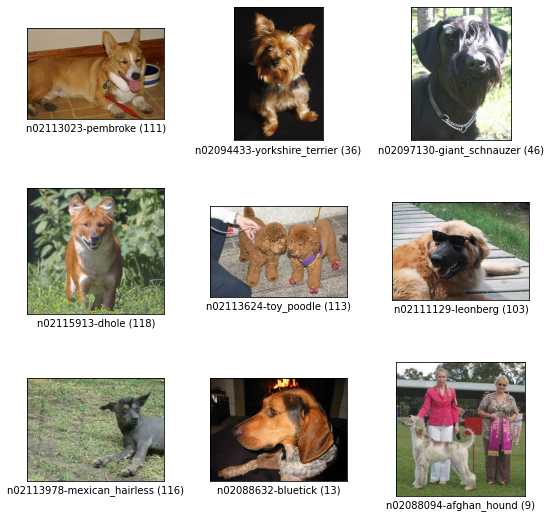

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
# set seed
def seed_everything(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

seed = 42
seed_everything(seed)

## 1. Augmentation을 적용한 데이터셋 만들기

### CutMix

In [5]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [6]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [7]:
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [8]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### MixUp

In [9]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [10]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [11]:
# 기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [12]:
# augmentation 함수
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [13]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
num_classes = ds_info.features["label"].num_classes

In [16]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True) # test dataset에는 augmentation 적용 X

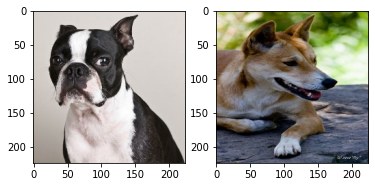

In [17]:
# 확인
# 데이터셋에서 이미지 2개를 가져오기 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [18]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(196, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(135, shape=(), dtype=int32)


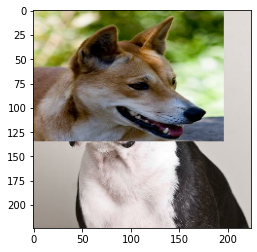

In [19]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [20]:
mixed_label = mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.47265625,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

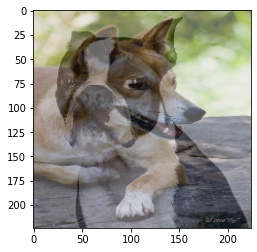

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.42506278 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [21]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

## 2. 모델 만들기

In [22]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [23]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [25]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [26]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

## 3. 모델 훈련하기

In [27]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
BATCH_SIZE = 16

In [28]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 204ms/step - loss: 2.1919 - accuracy: 0.4493 - val_loss: 3.1498 - val_accuracy: 0.2427
Epoch 2/20
750/750 [==============================] - 152s 202ms/step - loss: 0.7061 - accuracy: 0.8088 - val_loss: 1.3950 - val_accuracy: 0.5983
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.2161 - accuracy: 0.9552 - val_loss: 0.9248 - val_accuracy: 0.7263
Epoch 4/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0632 - accuracy: 0.9946 - val_loss: 0.9162 - val_accuracy: 0.7383
Epoch 5/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0276 - accuracy: 0.9989 - val_loss: 0.9249 - val_accuracy: 0.7421
Epoch 6/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0187 - accuracy: 0.9990 - val_loss: 0.9251 - val_accuracy: 0.7417
Epoch 7/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0135 - accuracy: 0.9997 - val_loss: 0.9430 -

In [29]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 159s 203ms/step - loss: 2.1978 - accuracy: 0.4529 - val_loss: 3.5204 - val_accuracy: 0.1938
Epoch 2/20
750/750 [==============================] - 151s 202ms/step - loss: 0.8398 - accuracy: 0.7647 - val_loss: 1.0485 - val_accuracy: 0.6845
Epoch 3/20
750/750 [==============================] - 167s 222ms/step - loss: 0.4102 - accuracy: 0.8914 - val_loss: 1.0972 - val_accuracy: 0.6848
Epoch 4/20
750/750 [==============================] - 152s 202ms/step - loss: 0.1972 - accuracy: 0.9564 - val_loss: 1.0294 - val_accuracy: 0.7157
Epoch 5/20
750/750 [==============================] - 151s 202ms/step - loss: 0.1004 - accuracy: 0.9849 - val_loss: 1.0211 - val_accuracy: 0.7233
Epoch 6/20
750/750 [==============================] - 151s 202ms/step - loss: 0.0561 - accuracy: 0.9932 - val_loss: 0.9460 - val_accuracy: 0.7425
Epoch 7/20
750/750 [==============================] - 151s 202ms/step - loss: 0.0333 - accuracy: 0.9969 - val_loss: 1.0766 -

In [30]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 205ms/step - loss: 3.7898 - accuracy: 0.2206 - val_loss: 3.4265 - val_accuracy: 0.2175
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.9285 - accuracy: 0.4423 - val_loss: 1.4359 - val_accuracy: 0.5913
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 2.6150 - accuracy: 0.5413 - val_loss: 1.3838 - val_accuracy: 0.6257
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.3923 - accuracy: 0.6143 - val_loss: 1.2658 - val_accuracy: 0.6514
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.2554 - accuracy: 0.6593 - val_loss: 1.5042 - val_accuracy: 0.6016
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 2.1401 - accuracy: 0.6932 - val_loss: 1.1185 - val_accuracy: 0.6912
Epoch 7/20
750/750 [==============================] - 153s 205ms/step - loss: 2.0515 - accuracy: 0.7231 - val_loss: 1.2710 -

In [31]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 3.7050 - accuracy: 0.2365 - val_loss: 3.8242 - val_accuracy: 0.1431
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 2.8859 - accuracy: 0.4705 - val_loss: 1.4889 - val_accuracy: 0.5803
Epoch 3/20
750/750 [==============================] - 153s 205ms/step - loss: 2.5944 - accuracy: 0.5796 - val_loss: 1.2961 - val_accuracy: 0.6391
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 2.4125 - accuracy: 0.6453 - val_loss: 1.3778 - val_accuracy: 0.6187
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 2.2844 - accuracy: 0.6936 - val_loss: 1.3727 - val_accuracy: 0.6252
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 2.1681 - accuracy: 0.7398 - val_loss: 1.2521 - val_accuracy: 0.6561
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 2.0989 - accuracy: 0.7570 - val_loss: 1.2654 -

## 4. 훈련 과정 시각화

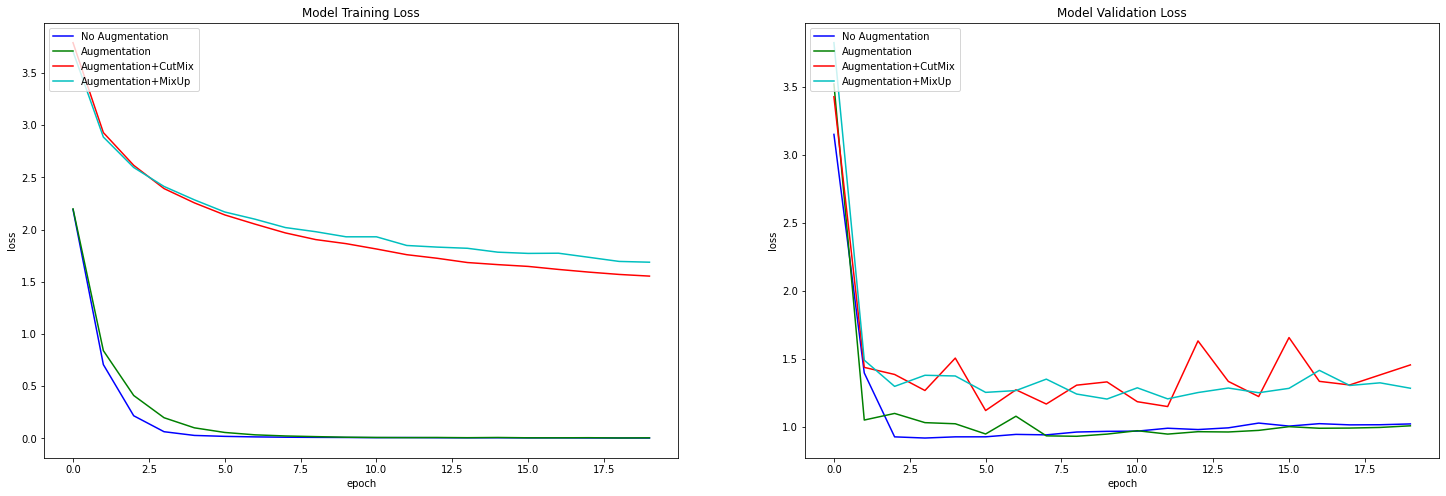

In [32]:
plt.figure(figsize=(25,8))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug.history['loss'], 'g')
plt.plot(history_resnet50_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['loss'], 'c')
plt.title('Model Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['No Augmentation', 'Augmentation', 'Augmentation+CutMix', 'Augmentation+MixUp'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug.history['val_loss'], 'g')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'r')
plt.plot(history_resnet50_mixup.history['val_loss'], 'c')
plt.title('Model Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['No Augmentation', 'Augmentation', 'Augmentation+CutMix', 'Augmentation+MixUp'], loc='upper left')
plt.show()

## 5. 성능 비교

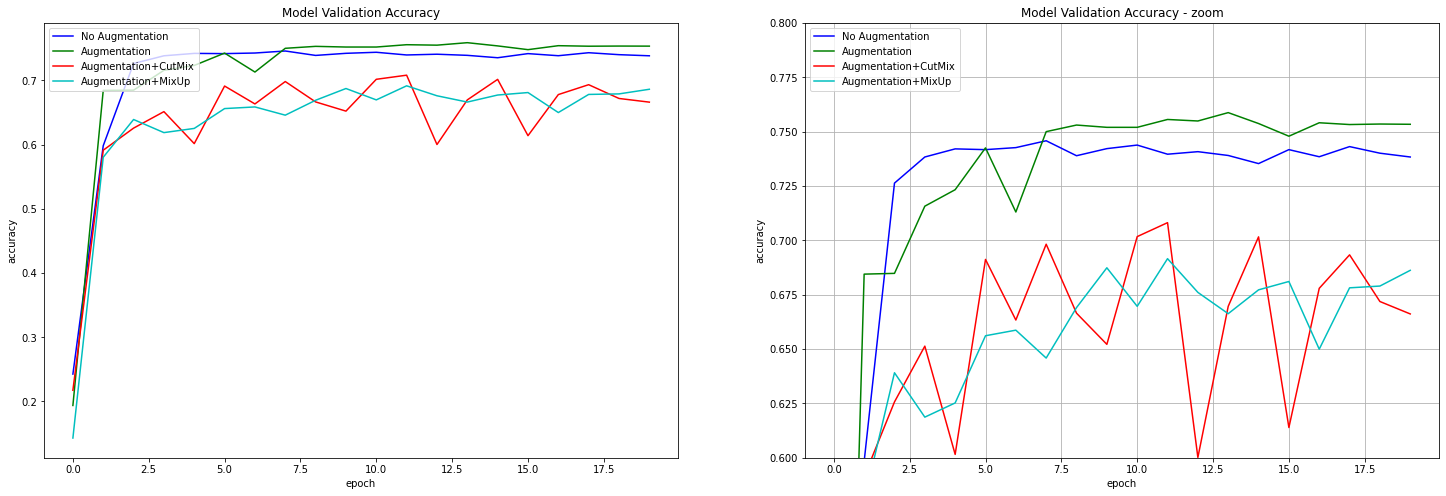

In [33]:
plt.figure(figsize=(25,8))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'c')
plt.title('Model Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['No Augmentation', 'Augmentation', 'Augmentation+CutMix', 'Augmentation+MixUp'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'c')
plt.title('Model Validation Accuracy - zoom')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['No Augmentation', 'Augmentation', 'Augmentation+CutMix', 'Augmentation+MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.80)
plt.show()

## 회고

- augmentation을 어떤 걸 적용하느냐에 따라 성능이 달라졌다.
- random_brightness를 제외했을 때 성능이 약간 더 좋았다.
- augmentation을 진행하지 않은 것과, augmentation만 진행한 것은 loss가 빠르게 수렴한 것으로 보이지만, train accuracy가 1에 가까운 것에 비하면 validation accuracy가 상당히 낮게 나왔다. 이는 overfitting이 되었다고 볼 수 있다.
- 반면 CutMix와 MixUp은 성능은 상대적으로 낮았지만 loss가 아직 수렴하지 않아 더 성능이 좋아질 여지가 보인다.
- CutMix와 MixUp 중에는 MixUp이 약간 더 높게 나왔다.
- 하이퍼파라미터 튜닝과 추가 학습으로 성능을 더 개선할 수 있을 것 같고, 그런 경우 augmentation을 진행하지 않은 것과, augmentation만 진행한 경우보다 더 좋은 성능의 모델을 얻을 수 있을 것 같다.